# Deep Reinforcement Q-Learning
## Banana Grabber Navigation Optimization


### 1. Importing libraries and Starting the Environment

Installation necessary to import unityagents package.

In [1]:
!pip -q install ./python

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Start the environment and initiating a *Brain* that will choose the Agents actions, in this case we'll work with only one Agent.

In [3]:
# Defining the environment, in this case the BananaGrabber
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Looking at the Environment

Below we are defining important variable that cotains some information about the possible states and actions for the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Passing through the Environment uncommitted

In the cell below, we'll run a episode, executing a random walk(choosing random actions) to interact with the environment, just to simulate what the algorithm will have to do to build the Q-Table.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0
steps = 0
# initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    steps += 1
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Making the Agent, intelligent

Our next step is to define the algorithm that'll define the best policy.<br>
To do so, we'll use a Deep Neural Network from Pytorch to mapping the best actions to states.<br>
For more about the architecture and techniques, please see the files:
- dqn_agent.py
- model.py

In [6]:
import torch
import timeit

from dqn_agent import Agent
from collections import deque

# I set the ideal values for the hyperparameters I found, but feel free to test other values
def dqn(n_episodes=2000, max_t=300, eps_start=1.0, eps_end=0.01, eps_decay=0.995, gamma=0.99, tau=1e-3, lr=5e-4, update_every=4):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        gamma (float): discount factor for learning step
        tau (float): value soft update of target parameters
        lr (float): learning rate(step size) to adjust hyperparameters
        update_every (int): how often to update the network
    """

    # Defining Agent
    agent = Agent(state_size=37, action_size=4, seed=0)
    agent.define_hyperparameters(gamma, tau, lr, update_every)
    
    start_time = timeit.default_timer()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    # Training episodes
    for i_episode in range(1, n_episodes+1):
        
        # Initial definition
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        # Start episode
        # loop through max_t steps(max steps are 300)
        for t in range(max_t):
            
            # Takes action
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            
            # Get state from environment
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        # Finish episode
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

    # for computing time
    elapsed = timeit.default_timer() - start_time
    return scores, elapsed

In [7]:
scores, time = dqn()

Episode 100	Average Score: 0.92
Episode 200	Average Score: 4.05
Episode 300	Average Score: 7.33
Episode 400	Average Score: 10.64
Episode 497	Average Score: 13.00
Environment solved in 397 episodes!	Average Score: 13.00


Once you have finished training, you can close the environment.

In [8]:
env.close()

### 5. About the results

In [9]:
print("It tooked %s second to reach average score > 13;" % (round(time, 2)))
print("And %s seconds in average to run each episose." % (round(time/len(scores), 2)))

It tooked 410.44 second to reach average score > 13;
And 0.83 seconds in average to run each episose.


Text(0,0.5,'Score')

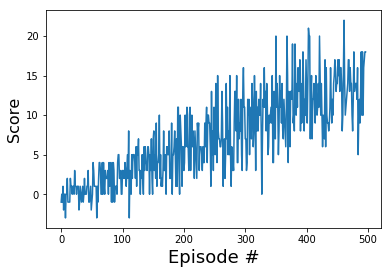

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(scores)
plt.xlabel('Episode #', fontsize=18)
plt.ylabel('Score', fontsize=16)

### End